In [1]:
# 투표 기반 분류기
import numpy as np

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

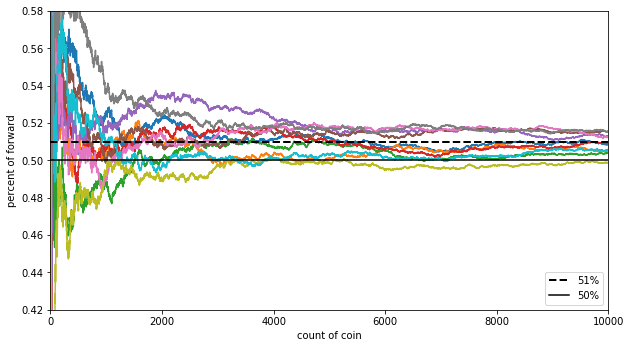

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")

plt.xlabel("count of coin")
plt.ylabel("percent of forward")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 직접 투표
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [6]:
# 간접 투표
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [7]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


In [8]:
# 간접 투표가 직접 투표보다 정확도가 높음

In [9]:
# 배깅과 앙상블
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42) # 배깅은 bootstrp = True, 페이스팅은 bootstrp = False

pas_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1, random_state=42) # 배깅은 bootstrp = True, 페이스팅은 bootstrp = False

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

pas_clf.fit(X_train, y_train)
y_pred = pas_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.912


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
# 단일 결정 트리 vs 배깅 앙상블 트리
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

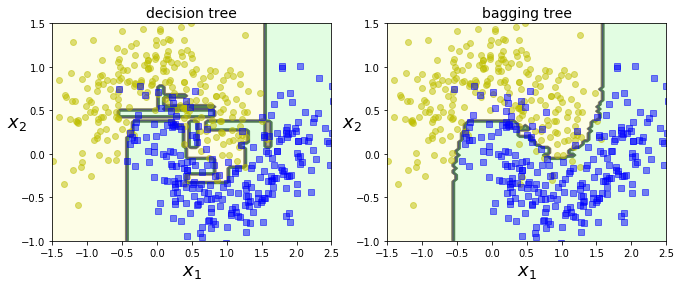

In [13]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("decision tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("bagging tree", fontsize=14)

plt.show()

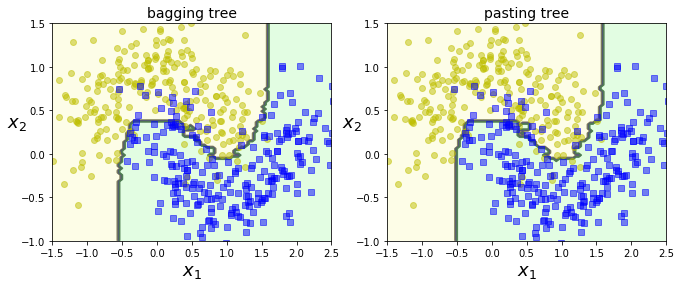

In [14]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(bag_clf, X, y)
plt.title("bagging tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(pas_clf, X, y)
plt.title("pasting tree", fontsize=14)

plt.show()

In [15]:
# oob 평가(배깅 알고리즘만 가능, 페이스팅은 안됨)
bag_clf.oob_score_

0.9253333333333333

In [16]:
bag_clf.oob_decision_function_

array([[0.35849057, 0.64150943],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.0128866 , 0.9871134 ],
       [0.03174603, 0.96825397],
       [0.07928389, 0.92071611],
       [0.4027027 , 0.5972973 ],
       [0.06703911, 0.93296089],
       [0.92950392, 0.07049608],
       [0.88461538, 0.11538462],
       [0.59351621, 0.40648379],
       [0.04896907, 0.95103093],
       [0.7591623 , 0.2408377 ],
       [0.82908163, 0.17091837],
       [0.88279302, 0.11720698],
       [0.07407407, 0.92592593],
       [0.04488778, 0.95511222],
       [0.92307692, 0.07692308],
       [0.70737913, 0.29262087],
       [0.94358974, 0.05641026],
       [0.06366048, 0.93633952],
       [0.22933333, 0.77066667],
       [0.91002571, 0.08997429],
       [0.98746867, 0.01253133],
       [0.96236559, 0.03763441],
       [0.        , 1.        ],
       [0.94255875, 0.05744125],
       [1.        , 0.        ],
       [0.02933333, 0.97066667],
       [0.70454545, 0.29545455],
       [0.

In [17]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [18]:
# 특성 샘플링
# 1. 랜덤 패치: 훈련 특성과 샘플 모두 사용
# 2. 랜덤 서브스페이스: 훈련 특성은 샘플 / 훈련 샘플은 모두 사용

# 1. 랜덤 패치
# base_estimator, n_estimators, max_samples, max_features, bootstrap, bootstrap_features
# oob_score, warm_start, n_jobs, random_state, verbose
bag_fetch_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                                  n_estimators=500,
                                  max_samples=1.0,  # 모든 샘플 사용
                                  max_features=1.0, # 모든 특성 사용
                                  bootstrap=True,   # 중복이 허용되는 배깅 알고리즘
                                  bootstrap_features=False, # 특성을 샘플링하지 않음
                                  oob_score=True,   # oob_score 확인
                                  n_jobs=-1,
                                  random_state=42)
bag_fetch_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [19]:
y_pred = bag_fetch_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [20]:
# 2. 랜덤 서브스페이스
bag_space_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                                  n_estimators=500,
                                  max_samples=1.0,   # 모든 샘플 사용
                                  max_features=0.6,  # 일부 특성 사용
                                  bootstrap=False,   # 중복이 허용되지 않는 페이스팅 알고리즘
                                  bootstrap_features=True, # 특성을 샘플링함
                                  oob_score=False,   # oob_score 확인 불가
                                  n_jobs=-1,
                                  random_state=42)
bag_space_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [21]:
y_pred = bag_space_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.784

In [22]:
# 랜덤 포레스트(위의 2가지 모두를 한 번에 사용 가능)
from sklearn.ensemble import RandomForestClassifier

# n_estimators, crietrion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf,
# max_features, max_leaf_nodes, min_impurity_decrease, min_impurity_split, bootstrap,
# oob_score, n_jobs, random_state, verbose, warm_state, class_weight, ccp_alpha, max_samples
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 oob_score=True,
                                 n_jobs=-1,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

In [24]:
# 위의 랜덤 포레스트와 비슷하게 만든 배깅 알고리즘
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=16,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
    

In [25]:
y_pred_bf = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bf) # 거의 비슷

0.92

In [26]:
# 붓꽃 데이터에서의 특성 중요도(RandomForestClassifier vs ExtraTreesClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.2, random_state=0)


# 그리드 탐색을 통한 파라미터 추정
# n_estimators, crietrion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf,
# max_features, max_leaf_nodes, min_impurity_decrease, min_impurity_split, bootstrap,
# oob_score, n_jobs, random_state, verbose, warm_state, class_weight, ccp_alpha, max_samples
rnd_grid = {
#     'n_estimators': [100, 200, 500],
#     'criterion' :['gini', 'entropy'],
#     'max_depth' : [2, 3, 4, 5],
#     'min_samples_split': [2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_leaf_nodes': list(range(2, 100)),
#     'bootstrap': [True, False],
    'n_jobs': [-1],
}

ext_grid = {
#     'n_estimators': [100, 200, 500],
#     'criterion' :['gini', 'entropy'],
#     'max_depth' : [2, 3, 4, 5],
#     'min_samples_split': [2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_leaf_nodes': list(range(2, 100)),
#     'bootstrap': [True, False],
    'n_jobs': [-1],
}

# 교차 검증을 위해
kfold = KFold(n_splits=10, shuffle=True, random_state=0) # stratified cross-validation

# 모델 선택
rnd_clf = RandomForestClassifier()
ext_clf = ExtraTreesClassifier()

# 파라미터 추정
rnd_grid_search = GridSearchCV(rnd_clf, rnd_grid, cv=kfold)
ext_grid_search = GridSearchCV(ext_clf, ext_grid, cv=kfold)

rnd_grid_search.fit(X_train, y_train)
ext_grid_search.fit(X_train, y_train)

# 결과
print('RandomForestClassifier 최적 매개변수 점수 ==> {:.3f}'.format(rnd_grid_search.best_score_))
print('RandomForestClassifier 최적 매개변수 ==> {}'.format(rnd_grid_search.best_params_))
print('RandomForestClassifier 최적 매개변수의 테스트 점수 ==> {:.3f}'.format(rnd_grid_search.score(X_test, y_test)))
print('RandomForestClassifier 최적 측정기 ==> {}'.format(rnd_grid_search.best_estimator_))
print('\n')
print('ExtraTreesClassifier 최적 매개변수 점수 ==> {:.3f}'.format(ext_grid_search.best_score_))
print('ExtraTreesClassifier 최적 매개변수 ==> {}'.format(ext_grid_search.best_params_))
print('ExtraTreesClassifier 최적 매개변수의 테스트 점수 ==> {:.3f}'.format(ext_grid_search.score(X_test, y_test)))
print('ExtraTreesClassifier 최적 측정기 ==> {}'.format(ext_grid_search.best_estimator_))

RandomForestClassifier 최적 매개변수 점수 ==> 0.933
RandomForestClassifier 최적 매개변수 ==> {'n_jobs': -1}
RandomForestClassifier 최적 매개변수의 테스트 점수 ==> 1.000
RandomForestClassifier 최적 측정기 ==> RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


ExtraTreesClassifier 최적 매개변수 점수 ==> 0.942
ExtraTreesClassifier 최적 매개변수 ==> {'n_jobs': -1}
ExtraTreesClassifier 최적 매개변수의 테스트 점수 ==> 1.000
ExtraTreesClassifier 최적 측정기 ==> ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gin

In [27]:
opt_rnd_clf = rnd_grid_search.best_estimator_.fit(X_train, y_train)

y_opt_rnd_pred = opt_rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_opt_rnd_pred))

1.0


In [28]:
opt_ext_clf = ext_grid_search.best_estimator_.fit(X_train, y_train)

y_opt_ext_pred = opt_ext_clf.predict(X_test)
print(accuracy_score(y_test, y_opt_ext_pred))

1.0


In [29]:
# 붓꽃 데이터의 전체 훈련 데이터를 가지고 특성 중요도 확인
opt_ext_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], opt_ext_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09540748612448925
sepal width (cm) 0.048718357373004735
petal length (cm) 0.3946858968131239
petal width (cm) 0.461188259689382


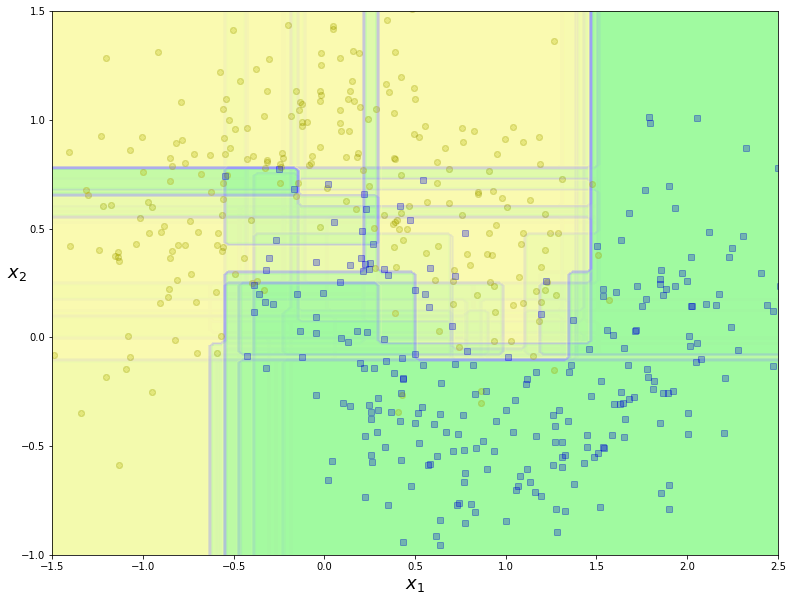

In [30]:
plt.figure(figsize=(13, 10))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

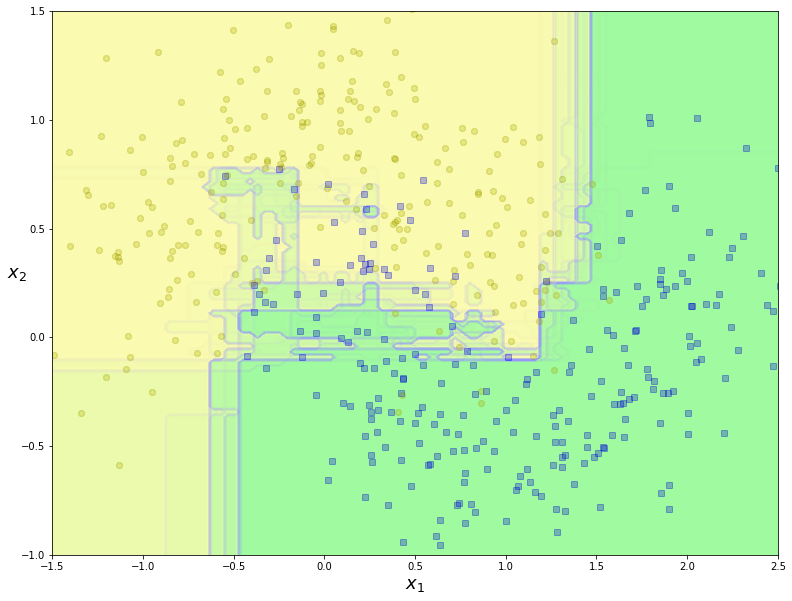

In [31]:
plt.figure(figsize=(13, 10))

for i in range(15):
    tree_clf = RandomForestClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

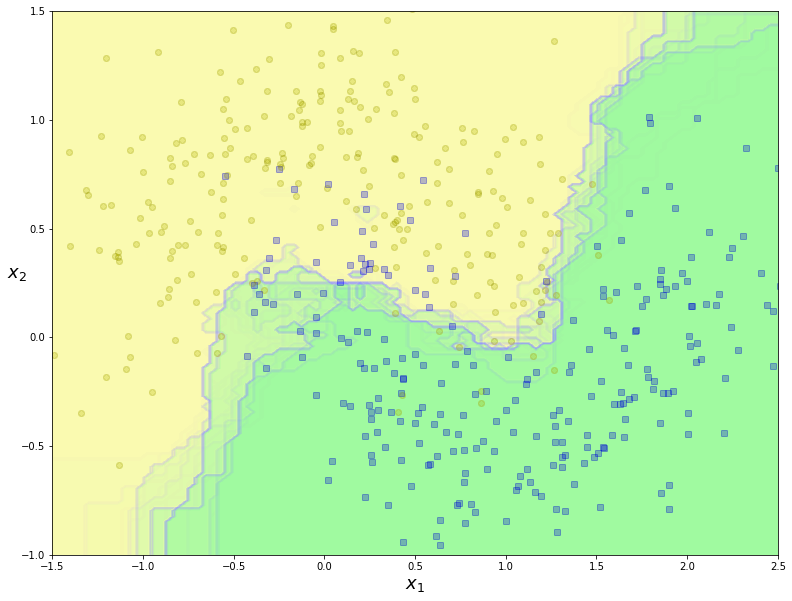

In [32]:
plt.figure(figsize=(13, 10))

for i in range(15):
    tree_clf = ExtraTreesClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

In [33]:
# MNIST 데이터의 특성 중요도
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [34]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.figure(figsize=(13, 10))
    plt.imshow(image, cmap=matplotlib.cm.hot, interpolation='nearest')
    plt.axis('off')

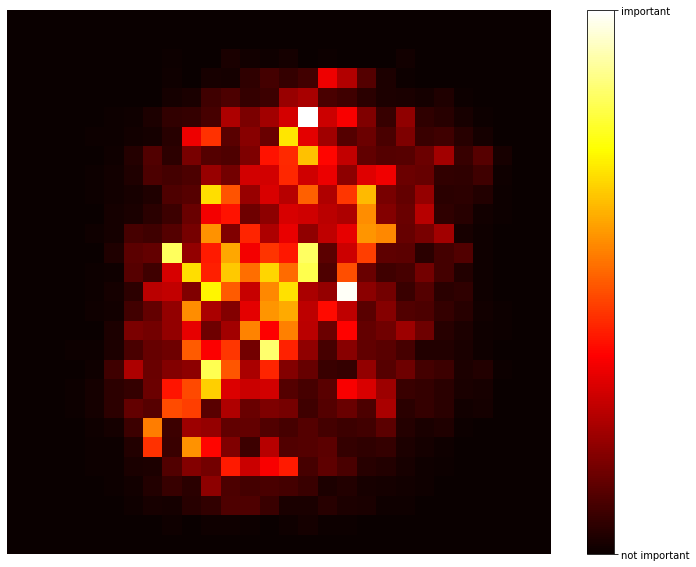

In [36]:
import matplotlib.pyplot as plt
import matplotlib

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['not important', 'important'])

plt.show()

In [37]:
rnd_clf = RandomForestClassifier(n_estimators=30, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.figure(figsize=(13, 10))
    plt.imshow(image, cmap=matplotlib.cm.hot, interpolation='nearest')
    plt.axis('off')

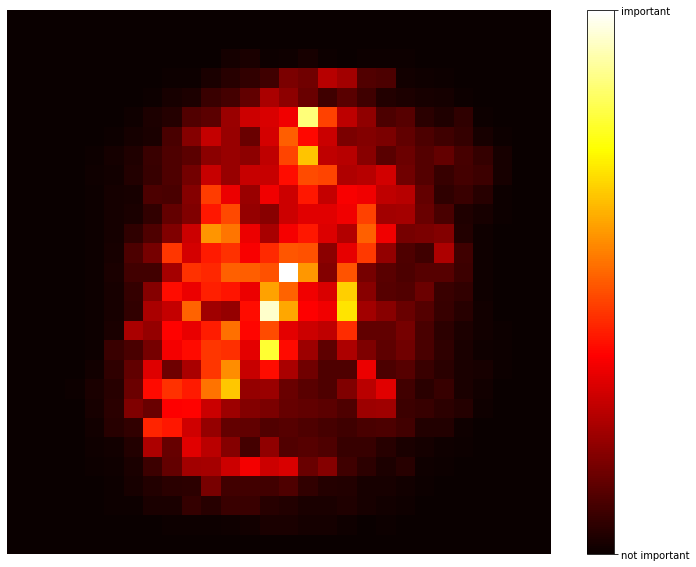

In [39]:
import matplotlib.pyplot as plt
import matplotlib

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['not important', 'important'])

plt.show()

In [40]:
# 부스팅 : 약한 학습기를 연결하여 강한 학습기를 만든느 앙상블 방법
# 1) 아다부스트
# 2) 그래디언트 부스팅

# 아다부스트
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

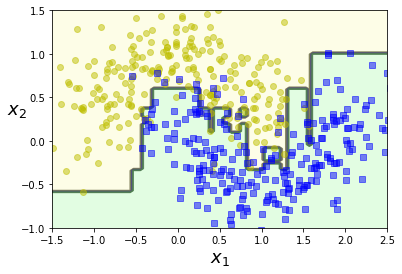

In [41]:
plot_decision_boundary(ada_clf, X, y)

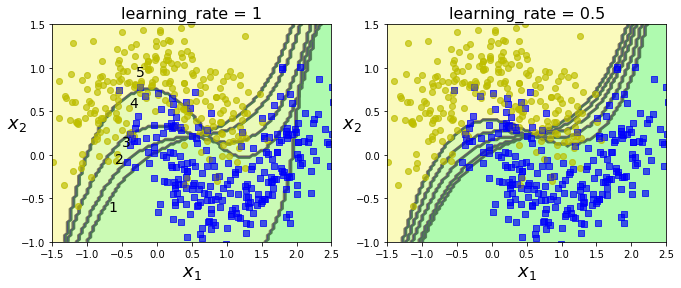

In [42]:
m = len(X_train)

plt.figure(figsize=(11, 4))

for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
        
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
        
plt.show()

In [43]:
ada_clf.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=

In [44]:
ada_clf.feature_importances_

array([0.535, 0.465])

In [45]:
# 그래디언트 부스팅
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [47]:
y2 = y - tree_reg1.predict(X) # 첫 번째 예측기에서 생긴 잔여 오차
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [48]:
y3 = y2 - tree_reg2.predict(X) # 두 번째 예측기에서 생긴 잔여 오차
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [49]:
X_new = np.array([[0.8]])

In [50]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [51]:
y_pred

array([0.75026781])

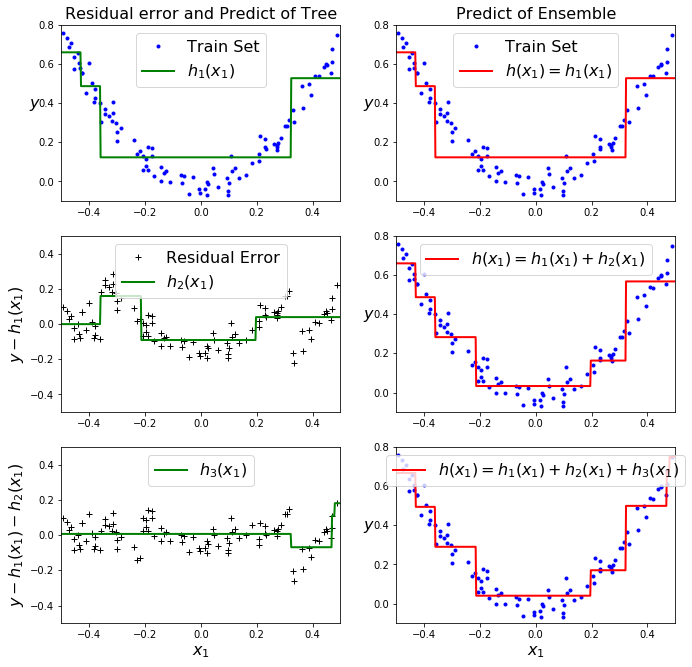

In [52]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Train Set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residual error and Predict of Tree", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Train Set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Predict of Ensemble", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residual Error")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [53]:
# 왼쪽 열은 세 개의 각각의 트리의 예측률, 오른쪽 열은 앙상블 기법
# 잔여 오차를 학습시킬 수록 더욱 예측이 좋아짐을 보임
# 위의 잔여 오차를 학습시키는 앙상블 기법과 같은 방식 = GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
gbrt_slow2 = GradientBoostingRegressor(max_depth=2, n_estimators=1000, learning_rate=0.1, random_state=42)
gbrt_slow2.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

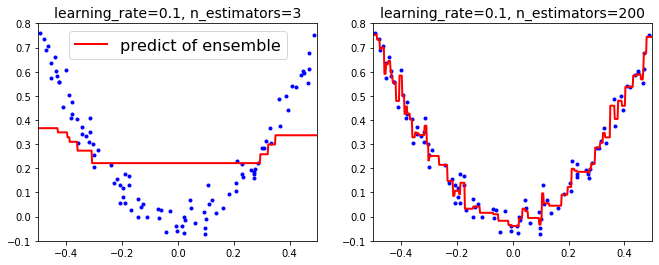

In [56]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="predict of ensemble")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

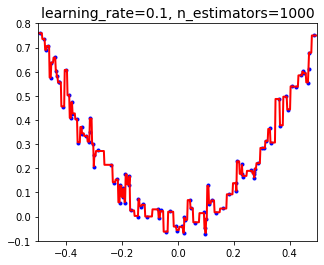

In [57]:
plt.figure(figsize=(5., 4))
plot_predictions([gbrt_slow2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow2.learning_rate, gbrt_slow2.n_estimators), fontsize=14)

plt.show()

In [58]:
# 최적의 트리의 개수를 찾기 위한 조기 종료 기법
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수 찾기
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
min_error = np.min(errors)

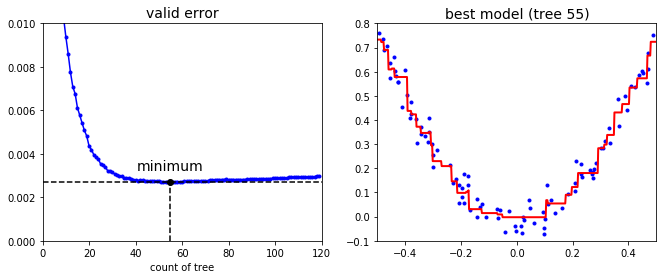

In [60]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("count of tree")
plt.title("valid error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("best model (tree %d)" % bst_n_estimators, fontsize=14)

plt.show()

In [61]:
# 위의 방법은 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾는 방법

In [62]:
# 아래의 방법은 실제로 훈련을 중지하는 방법
# warm_start = True로 설정하면 사이킷런이 fit() 메소드가 호출될 때 기존 트리를 유지하고 훈련 추가 가능

# 다음은 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련 중단
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 조기 종료

In [63]:
print(gbrt.n_estimators)

61


In [64]:
print("최소 검증 MSE:", min_val_error)

최소 검증 MSE: 0.002712853325235463


In [1]:
# 스태킹
# 사이킷런은 제공 안함 -> 직접 구현 or brew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_moons
import xgboost

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
if xgboost is not None:  # 책에는 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

[16:58:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[16:58:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)